In [1]:
!pip install --quiet --upgrade pip
!pip install --quiet "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [2]:
import time
import csv
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

Print out all devices; the first GPU (if present) is typically device 0.

In [3]:
print("JAX devices:", jax.devices())

JAX devices: [CudaDevice(id=0)]


User-configurable dtype (choose from float32, float64, complex64, complex128)

In [4]:
dtype_str = "float32"

Map dtype string to JAX and NumPy types

In [5]:
jax_dtype = getattr(jnp, dtype_str)
np_dtype = getattr(np, dtype_str)

In [6]:
def generate_random_batch(B, m, n):
    """
    Generate a batch of random matrices with shape (B, m, n).
    Supports complex dtype.
    """
    if np.dtype(np_dtype).kind == 'c':  # Complessi
        real_part = np.random.randn(B, m, n).astype(np_dtype(0).real.dtype)
        imag_part = np.random.randn(B, m, n).astype(np_dtype(0).real.dtype)
        return real_part + 1j * imag_part
    else:
        return np.random.randn(B, m, n).astype(np_dtype)

In [7]:
def batched_svals_on_device(batch_jax: jnp.ndarray) -> jnp.ndarray:
    """
    Compute the only singular values of a batch of matrices on the device.

    Args:
      batch_jax: array JAX di shape (B, m, n).

    Returns:
      S_j: array JAX di shape (B, K), with K = min(m, n).
    """
    # compute_uv=False skips the computation of U and Vh
    S_j = jnp.linalg.svd(batch_jax, full_matrices=False, compute_uv=False)
    return S_j

Warmup execution...
B=   32 | time=0.000517s | avg_rel_error=3.709e-07
B=   64 | time=0.049138s | avg_rel_error=3.706e-07
B=  128 | time=0.047907s | avg_rel_error=3.563e-07
B=  256 | time=0.050278s | avg_rel_error=3.439e-07
B=  512 | time=0.051534s | avg_rel_error=3.486e-07
B= 1024 | time=0.052569s | avg_rel_error=3.418e-07
B= 2048 | time=0.056179s | avg_rel_error=3.593e-07
B= 4096 | time=0.065680s | avg_rel_error=3.452e-07
B= 8192 | time=0.079391s | avg_rel_error=3.504e-07
B=16384 | time=0.110176s | avg_rel_error=3.521e-07
Results saved in results_svals_jax.csv


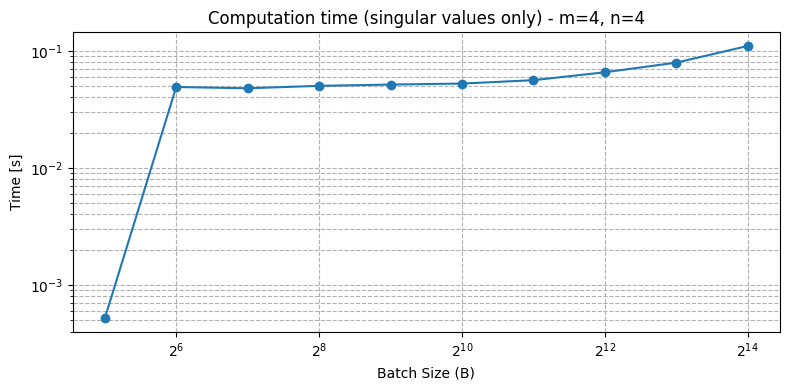

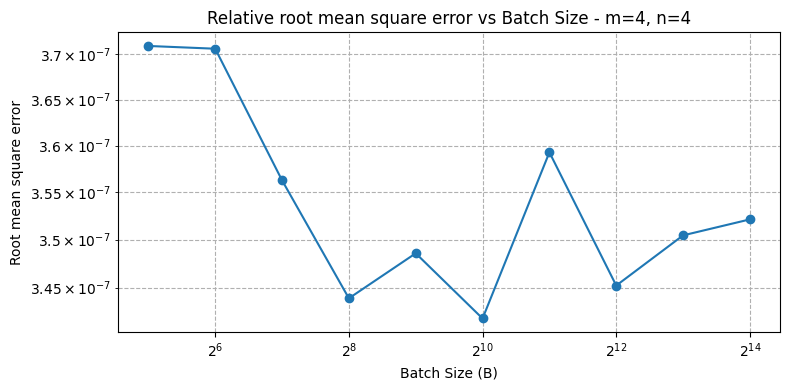

In [8]:
if __name__ == "__main__":
    # Matrix dimensions
    m = 4
    n = 4
    batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

    # Warmup on GPU
    print("Warmup execution...")
    warmup_batch = generate_random_batch(32, m, n)
    warmup_jax = jnp.array(warmup_batch, dtype=jax_dtype)
    S_warm = batched_svals_on_device(warmup_jax)
    # Block until ready
    S_warm.block_until_ready()

    elapsed_times = []
    avg_errors = []

    for B in batch_sizes:
        # Generate a batch and move it to the GPU
        batch_np = generate_random_batch(B, m, n)
        batch_jax = jnp.array(batch_np, dtype=jax_dtype)

        # Timing
        start = time.time()
        S_j = batched_svals_on_device(batch_jax)
        S_j.block_until_ready()
        elapsed = time.time() - start
        elapsed_times.append(elapsed)

        # Accuracy: comparison against NumPy
        # Compute reference singular values on the CPU
        S_ref = np.linalg.svd(batch_np.reshape(-1, m, n), compute_uv=False)
        # np.linalg.svd on batch is supported by NumPy >=1.22, otherwise loop
        if isinstance(S_ref, tuple):
            # if NumPy returns tuple (U,S,Vh)
            S_ref = S_ref[1]
        # Compute the root mean square error
        # Align S_j and S_ref:
        S_j_np = np.array(S_j)
        rel_errors = np.linalg.norm(S_j_np - S_ref, axis=1) / np.linalg.norm(S_ref, axis=1)
        avg_err = np.mean(rel_errors)
        avg_errors.append(avg_err)

        print(f"B={B:5d} | time={elapsed:.6f}s | avg_rel_error={avg_err:.3e}")

    # Save the results on CSV file
    filename = "results_svals_jax.csv"
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["batch_size", "elapsed_time", "avg_rel_error"])
        for B, t, e in zip(batch_sizes, elapsed_times, avg_errors):
            writer.writerow([B, t, e])
    print(f"Results saved in {filename}")

    # Plot
    B_arr = np.array(batch_sizes)
    t_arr = np.array(elapsed_times)
    e_arr = np.array(avg_errors)

    plt.figure(figsize=(8, 4))
    plt.plot(B_arr, t_arr, marker='o')
    plt.title(f"Computation time (singular values only) - m={m}, n={n}")
    plt.xlabel("Batch Size (B)")
    plt.ylabel("Time [s]")
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.grid(True, which='both', ls='--')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(B_arr, e_arr, marker='o')
    plt.title(f"Relative root mean square error vs Batch Size - m={m}, n={n}")
    plt.xlabel("Batch Size (B)")
    plt.ylabel("Root mean square error")
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.grid(True, which='both', ls='--')
    plt.tight_layout()
    plt.show()